In [2]:
#load libraries
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima   

In [3]:
pwd

'/Users/panos/Documents/Work/aueb/students/darzanos/LoadPrediction'

In [4]:
#load folder-the actual data were given in 17 separate excel files
files = os.listdir('dataLoad')
files

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Load Demand_Forecast.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [5]:
#list of files to loop-only xlsx
files_xls = [f for f in files if 'Cons_Report' in f]
files_xls

['Cons_Report_122018.xlsx',
 'Cons_Report_052019.xlsx',
 'Cons_Report_042019.xlsx',
 'Cons_Report_052018.xlsx',
 'Cons_Report_042018.xlsx',
 'Cons_Report_022018.xlsx',
 'Cons_Report_032018.xlsx',
 'Cons_Report_082018.xlsx',
 'Cons_Report_092018.xlsx',
 'Cons_Report_022019.xlsx',
 'Cons_Report_032019.xlsx',
 'Cons_Report_062018.xlsx',
 'Cons_Report_072018.xlsx',
 'Cons_Report_112018.xlsx',
 'Cons_Report_102018.xlsx',
 'Cons_Report_012019.xlsx',
 'Cons_Report_012018.xlsx']

In [6]:
#create one dataframe from all the excel files
actual = pd.DataFrame()
for f in files_xls:
    data = pd.read_excel('dataLoad/' + f)
    actual=actual.append(data, ignore_index=True)

In [7]:
#get column names
actual.columns

Index(['deliveryDay', 'Hour_EET', 'Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network',
       'Total'],
      dtype='object')

In [8]:
#rename columns
actual.columns=['Date','Hour','Gen_Aux', 'HV', 'Pump', 'TEL_MV', 'Network','ActualTotal']
actual.head()

,Date,Hour,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,2018-12-01,1,33.006141,934.808670,0.0,954.722055,4595.257242,5563.072052
1,2018-12-01,2,43.988918,959.233194,0.0,931.364922,4063.666352,5066.888464
2,2018-12-01,3,46.329801,970.324019,0.0,910.726163,3938.994044,4955.647864
3,2018-12-01,4,36.405052,995.836951,0.0,901.447118,3755.516237,4787.758241
4,2018-12-01,5,36.149028,991.074298,0.0,896.550351,3646.883398,4674.106724


- Date,Hour=Ημερομηνια Αναφοράς
- Gen_Aux=φορτιο παραγωγής μονάδων
- HV=Φορτίο Υψηλής τάσης
- Pump=Αναμενω ενημέρωση
- Network (ΜΤ+ΧΤ)= μας δίνει το συνολικό actual φορτίο
- TEL_MV=Φορτιο της τηλεμετρουμενης μεσης τασης.
- ΧΤ= Η στηλη που δημιουργώ αφαιρώντας την τηλεμετρουμενη ΜΤ από το Network και βρίσκω την actual total XT που θέλω να προβλεψω.
- ActualTotal= Το αθροισμα των Network+HV+Gen_Aux+Pump που μας δίνει το συνολικό φορτίο. Αυτό θα το χρησιμοποιήσω αργότερα για να βρω τι ποσοστό είναι η ΧΤ σε σχέση με το ActualTotal.



In [9]:
#load excel with forecast of the current program
forecast=pd.read_excel("dataLoad/Load Demand_Forecast.xlsx")

In [10]:
forecast.head()

,Year,Month,Weekday,Holiday,Date,1,2,3,4,5,...,21,22,23,24,Sum,Avrg,Max,Min,Δ vs D-1,Δ vs D-7
0,2018,1,1,1,2018-01-01,5315.0,4963.0,4838.0,4515.0,4280.0,...,6198.0,6021.0,5756.0,5513.0,127512.0,5313.000000,6237.0,4182.0,-0.112966,-0.077077
1,2018,1,2,0,2018-01-02,5023.0,4612.0,4573.0,4389.0,4250.0,...,6831.0,6517.0,6106.0,5717.0,135940.0,5664.166667,6927.0,4250.0,0.066096,-0.011101
2,2018,1,3,0,2018-01-03,5211.0,4761.0,4721.0,4547.0,4438.0,...,7409.0,6949.0,6411.0,5962.0,146200.0,6091.666667,7554.0,4438.0,0.075474,-0.001666
3,2018,1,4,0,2018-01-04,5307.0,4788.0,4721.0,4525.0,4427.0,...,7483.0,7014.0,6476.0,6038.0,149234.0,6218.083333,7649.0,4427.0,0.020752,0.020194
4,2018,1,5,0,2018-01-05,5420.0,4932.0,4865.0,4718.0,4621.0,...,7453.0,6984.0,6455.0,6037.0,149052.0,6210.500000,7550.0,4621.0,-0.001220,0.010892


In [11]:
#data manipulation to create new dataframe
forecast2=forecast[['Weekday',  'Holiday','Date', 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
prediction = pd.melt(forecast2, id_vars=["Weekday", "Holiday", "Date"])
prediction.head(10)

,Weekday,Holiday,Date,variable,value
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [12]:
prediction.tail(10)

,Weekday,Holiday,Date,variable,value
12374,3,0,2019-05-22,24,5066.0
12375,4,0,2019-05-23,24,5126.0
12376,5,0,2019-05-24,24,5092.0
12377,6,0,2019-05-25,24,4961.0
12378,7,0,2019-05-26,24,4802.0
12379,1,0,2019-05-27,24,5093.0
12380,2,0,2019-05-28,24,5088.0
12381,3,0,2019-05-29,24,5111.0
12382,4,0,2019-05-30,24,5185.0
12383,5,0,2019-05-31,24,5105.0


In [13]:
#rename columns
prediction.columns=[ 'Weekday', 'Holiday', 'Date', 'Hour', 'ForecastTotalLoad' ]
prediction.head(10)

,Weekday,Holiday,Date,Hour,ForecastTotalLoad
0,1,1,2018-01-01,1,5315.0
1,2,0,2018-01-02,1,5023.0
2,3,0,2018-01-03,1,5211.0
3,4,0,2018-01-04,1,5307.0
4,5,0,2018-01-05,1,5420.0
5,6,1,2018-01-06,1,5430.0
6,7,0,2018-01-07,1,5348.0
7,1,0,2018-01-08,1,5170.0
8,2,0,2018-01-09,1,5343.0
9,3,0,2018-01-10,1,5304.0


In [14]:
#εδω αφαίρω μια ωρα για να φτάσω στο format 0-23 ωρες ωστε να γλυτώσω αυτό με το timestamp + 1
actual['Hour']=actual['Hour']-1
prediction['Hour']=prediction['Hour']-1

- ForecastTotalLoad είναι η προβλεψη για το συνολικό actual φορτίο όπως την κάνουν τωρα και πρέπει να συγκριθεί με την αντίστοιχη τιμή πιο πανω του ActualTotal.

In [15]:
actual.set_index(['Date', 'Hour']).head()

Gen_Aux          HV  Pump      TEL_MV      Network  \
Date       Hour                                                         
2018-12-01 0     33.006141  934.808670   0.0  954.722055  4595.257242   
           1     43.988918  959.233194   0.0  931.364922  4063.666352   
           2     46.329801  970.324019   0.0  910.726163  3938.994044   
           3     36.405052  995.836951   0.0  901.447118  3755.516237   
           4     36.149028  991.074298   0.0  896.550351  3646.883398   

                 ActualTotal  
Date       Hour               
2018-12-01 0     5563.072052  
           1     5066.888464  
           2     4955.647864  
           3     4787.758241  
           4     4674.106724

In [16]:
prediction.set_index(['Date', 'Hour']).head()

,,Weekday,Holiday,ForecastTotalLoad
Date,Hour,,,
2018-01-01,0,1,1,5315.0
2018-01-02,0,2,0,5023.0
2018-01-03,0,3,0,5211.0
2018-01-04,0,4,0,5307.0
2018-01-05,0,5,0,5420.0


* Join the two dataframes.

In [17]:
final = pd.merge(prediction, actual, on=['Date', 'Hour'])
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090


In [18]:
final['Timestamp'] = final['Date'] + pd.to_timedelta(final['Hour'], unit='h')
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01
1,2,0,2018-01-02,0,5023.0,45.218816,751.513843,0.000,610.814364,4101.718326,4898.450985,2018-01-02
2,3,0,2018-01-03,0,5211.0,37.042898,904.679508,0.000,800.563658,4283.392261,5225.114667,2018-01-03
3,4,0,2018-01-04,0,5307.0,35.636497,918.203986,0.000,853.288369,4450.591164,5404.431647,2018-01-04
4,5,0,2018-01-05,0,5420.0,37.712368,961.116481,23.108,866.047536,4617.594242,5639.531090,2018-01-05


In [19]:
final.sort_values('Timestamp', inplace=True)
final.head()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
0,1,1,2018-01-01,0,5315.0,34.418093,757.020147,0.000,596.563993,4529.773678,5321.211918,2018-01-01 00:00:00
516,1,1,2018-01-01,1,4963.0,40.928810,760.024989,0.000,589.266551,4205.128845,5006.082645,2018-01-01 01:00:00
1032,1,1,2018-01-01,2,4838.0,39.286246,750.624526,0.000,585.334471,4116.742544,4906.653316,2018-01-01 02:00:00
1548,1,1,2018-01-01,3,4515.0,38.678094,756.567856,0.120,582.210175,3833.136857,4628.502808,2018-01-01 03:00:00
2064,1,1,2018-01-01,4,4280.0,37.498531,731.949138,130.176,581.251131,3608.455842,4508.079510,2018-01-01 04:00:00


In [20]:
final.tail()

,Weekday,Holiday,Date,Hour,ForecastTotalLoad,Gen_Aux,HV,Pump,TEL_MV,Network,ActualTotal,Timestamp
10319,5,0,2019-05-31,19,5572.0,33.211102,876.113437,0.0,1397.706018,4901.567117,5810.891656,2019-05-31 19:00:00
10835,5,0,2019-05-31,20,5740.0,32.731239,890.764508,0.0,1355.517513,5000.305264,5923.801011,2019-05-31 20:00:00
11351,5,0,2019-05-31,21,5915.0,32.180987,861.846122,0.0,1268.293778,5123.894570,6017.921678,2019-05-31 21:00:00
11867,5,0,2019-05-31,22,5506.0,33.389455,856.024205,0.0,1152.098123,4680.730403,5570.144063,2019-05-31 22:00:00
12381,5,0,2019-05-31,23,5105.0,35.753307,964.764549,0.0,1092.041595,4227.795192,5228.313048,2019-05-31 23:00:00


In [21]:
#create the column of interest
final['XT'] = final['Network'] - final['TEL_MV']

#find the percentage of XT as to total ActualLoad for that day and Hour (TrueValues)
final['%XTofTotal']=final['XT']/final['ActualTotal']

#find the estimation of XTPrediction
final['XTForecastEstimation']=final['%XTofTotal']*final['ForecastTotalLoad']


Στο παραπάνω κελι αφού δημιουργήσω τη στηλη με τις actual τιμές της ΧΤ υπολογίζω το ποσοστό που έπιανε η ΧΤ σε σχέση με το σύνολο του φορτίου για εκείνη τη μέρα ώρα. Βρίσκοντας το ποσοστό, το εφαρμόζω μετά στην πρόβλεψη που δίνει το μοντέλο τους (το μοντέλο τους προβλέπει το σύνολικό φορτίο του δυκτίου) για να μπορέσω να προσεγγίσω την πρόβλεψη του μοντέλου αν προέβλεπε τη χαμηλή τάση. Θα το χρησιμοποιήσω στη σύγκριση μεταξυ του δικού μας και του δικού τους μοντέλου όπως είπαμε.

In [22]:
#finalize dataset and set frequency
final=final[['Timestamp','XT','Weekday','Holiday','XTForecastEstimation']]
final.sort_values('Timestamp', inplace=True)
final.set_index('Timestamp', inplace=True)

In [23]:
final

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-01-01 00:00:00,3933.209685,1,1,3928.618104
2018-01-01 01:00:00,3615.862294,1,1,3584.743969
2018-01-01 02:00:00,3531.408073,1,1,3481.997027
2018-01-01 03:00:00,3250.926682,1,1,3171.205588
2018-01-01 04:00:00,3027.204711,1,1,2874.047836
2018-01-01 05:00:00,2934.418572,1,1,2624.699069
2018-01-01 06:00:00,2990.903843,1,1,2645.526199
2018-01-01 07:00:00,3048.662534,1,1,2778.846267
2018-01-01 08:00:00,3189.215049,1,1,3011.633638


* Check the index for the frequency (should be hourly).

In [24]:
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-05-31 14:00:00', '2019-05-31 15:00:00',
               '2019-05-31 16:00:00', '2019-05-31 17:00:00',
               '2019-05-31 18:00:00', '2019-05-31 19:00:00',
               '2019-05-31 20:00:00', '2019-05-31 21:00:00',
               '2019-05-31 22:00:00', '2019-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12382, freq=None)

* The `None` reported value indicates that there might be missing values.

In [25]:
#nice
pd.date_range(final.index.min(), final.index.max(), freq='H').difference(final.index)

DatetimeIndex(['2018-03-25 23:00:00', '2019-03-31 23:00:00'], dtype='datetime64[ns]', freq=None)

* Let's check what happens around the first date.

In [26]:
final.loc['2018-03-25':'2018-03-26']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 00:00:00,3147.824162,7,1,3171.278635
2018-03-25 01:00:00,2740.862797,7,1,2745.225070
2018-03-25 02:00:00,2654.360886,7,1,2648.583949
2018-03-25 03:00:00,2507.887529,7,1,NaN
2018-03-25 04:00:00,2440.072651,7,1,2506.587454
2018-03-25 05:00:00,2515.380769,7,1,2532.772226
2018-03-25 06:00:00,2612.671803,7,1,2604.791065
2018-03-25 07:00:00,2930.827226,7,1,2807.819204
2018-03-25 08:00:00,3306.252447,7,1,3126.662986


* There is a missing from March 25 to March 26, 2018.

* Let's also check what is happening with the second date.

In [27]:
final.loc['2019-03-31':'2019-04-01']

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2019-03-31 00:00:00,3301.206709,7,0,3247.902346
2019-03-31 01:00:00,2873.602290,7,0,2819.229247
2019-03-31 02:00:00,2747.037509,7,0,2732.615475
2019-03-31 03:00:00,2588.609454,7,0,2603.115607
2019-03-31 04:00:00,2508.161442,7,0,2440.825764
2019-03-31 05:00:00,2584.451302,7,0,2492.355395
2019-03-31 06:00:00,2782.655535,7,0,2586.818830
2019-03-31 07:00:00,3116.754635,7,0,2827.044553
2019-03-31 08:00:00,3392.986697,7,0,3069.195420


* Same story, an hour was skipped between March 31 and April 1, 2019.

* We'll fix the issue by using the previous value.

In [28]:
final = final.asfreq(freq='H', method='pad')
final.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2019-05-31 14:00:00', '2019-05-31 15:00:00',
               '2019-05-31 16:00:00', '2019-05-31 17:00:00',
               '2019-05-31 18:00:00', '2019-05-31 19:00:00',
               '2019-05-31 20:00:00', '2019-05-31 21:00:00',
               '2019-05-31 22:00:00', '2019-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=12384, freq='H')

In [29]:
#check again for NaN in dataframe γιατι τώρα που κουβαλάω και την επιπλέον στήλη εχω το ίδιο θέμα με την ώρα
final[final.isnull().any(axis=1)]

,XT,Weekday,Holiday,XTForecastEstimation
Timestamp,,,,
2018-03-25 03:00:00,2507.887529,7,1,NaN


In [30]:
#NaN that day for forecastedValues
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation            NaN
Name: 2018-03-25 03:00:00, dtype: float64

In [31]:
#fill with previous value ΝαΝ
final=final.fillna(method='ffill')

In [32]:
#fixed
final.loc['2018-03-25 03:00:00']

XT                      2507.887529
Weekday                    7.000000
Holiday                    1.000000
XTForecastEstimation    2648.583949
Name: 2018-03-25 03:00:00, dtype: float64

In [33]:
#Here is going to be the EDA part-just some quick insights

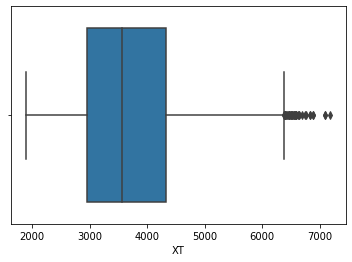

In [34]:
#there are some outliers
import seaborn as sns
sns.boxplot(x=final['XT'])

In [35]:
#check largest Values-seems logical not extreme values
print( final['XT'].nlargest(100))

Timestamp
2019-01-08 19:00:00    7187.273484
2019-01-08 18:00:00    7092.001648
2019-01-08 20:00:00    7087.291997
2019-01-07 19:00:00    6889.243639
2018-12-31 19:00:00    6886.460958
                          ...     
2019-01-07 14:00:00    6084.083217
2018-12-18 19:00:00    6070.501313
2019-02-24 19:00:00    6066.652340
2019-01-11 20:00:00    6064.160066
2018-12-19 18:00:00    6059.806308
Name: XT, Length: 100, dtype: float64


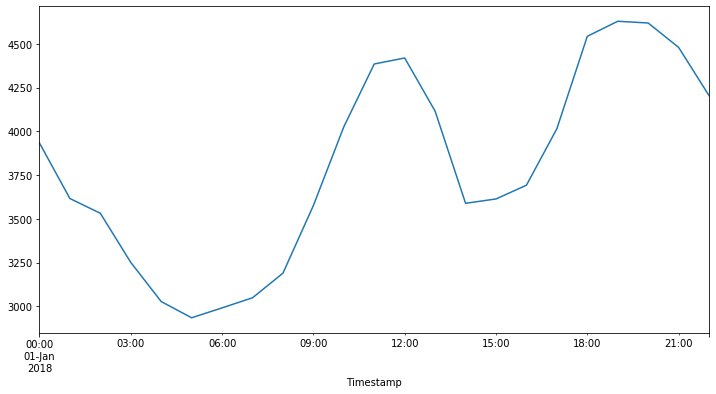

In [36]:
final['XT'].iloc[:23].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

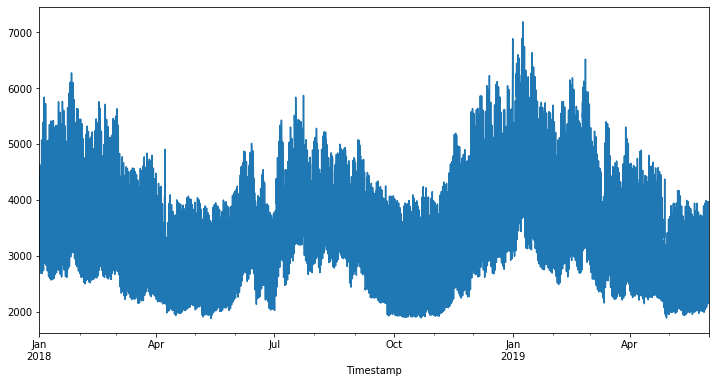

In [37]:
final['XT'].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Text(0, 0.5, 'Residual')

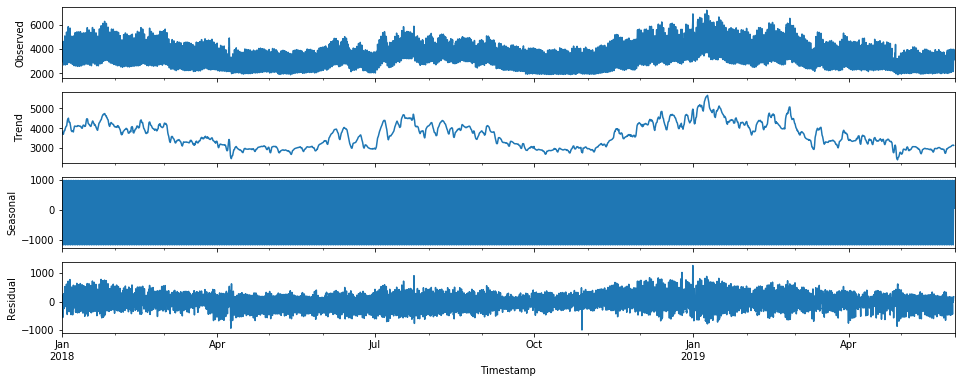

In [38]:
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,6))

result = seasonal_decompose(final['XT'])

result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

In [39]:
#create ad-fuller test function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [510]:
#what about that test???
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(series):
    print ('Results of KPSS Test:')
    kpsstest = kpss(series, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [511]:
kpss_test(final['XT'])

Results of KPSS Test:
Test Statistic            1.407177
p-value                   0.010000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


kpss Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, we fail to reject the null hypothesis (series is stationary). The value of the test statistic is greater than the critical value at all confidence intervals, and hence we can say that the series is not stationary.

In [512]:
adf_test(final['XT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.934115
p-value                     0.001798
# lags used                41.000000
# observations          12342.000000
critical value (1%)        -3.430880
critical value (5%)        -2.861774
critical value (10%)       -2.566895
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Στο analyticsVidhya διάβασα αυτό.
KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [42]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(final['XT'].loc['2018-05-01':'2019-05-01'], seasonal=True, m=24).summary()

C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:726: RuntimeWarning: divide by zero encountered in double_scalars
  (1 - np.sum(tra

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8784
Model:             SARIMAX(1, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -48743.621
Date:                            Sun, 21 Jul 2019   AIC                          97499.241
Time:                                    22:34:14   BIC                          97541.725
Sample:                                         0   HQIC                         97513.715
                                           - 8784                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0180      0.041      0.438      0.662      -0.063       0.099
ar.L1          0.5169      0.005     95.533      0.000       0.506       0.528
ar.S.L24       1.2276      0.009    143.719      0.000       1.211       1.244
ar.S.L48      -0.2278      0.009    -26.705      0.000      -0.245      -0.211
ma.S.L24      -0.8331      0.005   -164.946      0.000      -0.843      -0.823
sigma2      4571.9960     30.838    148.259      0.000    4511.555    4632.437
===================================================================================
Ljung-Box (Q):                     1761.39   Jarque-Bera (JB):             72836.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.61   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
#use the period used for training
df1=final.loc['2018-05-01':'2019-05-01']
df1.shape

(8784, 4)

* Use all data except the last two days for training and the last two days for testing.

In [43]:
train = df1.iloc[:-24*2]
test = df1.iloc[-24*2:]

In [87]:
#run model
model = SARIMAX(train['XT'],
                exog=train[['Weekday','Holiday']],
                order=(1,1,0),
                seasonal_order=(2,0,1,24),
                enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 XT   No. Observations:                 8736
Model:             SARIMAX(1, 1, 0)x(2, 0, 1, 24)   Log Likelihood              -48338.112
Date:                            Sun, 21 Jul 2019   AIC                          96690.225
Time:                                    23:18:31   BIC                          96739.750
Sample:                                05-01-2018   HQIC                         96707.102
                                     - 04-29-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Weekday        2.5268      1.185      2.133      0.033       0.205       4.849
Holiday       27.4477      6.499      4.224      0.000      14.711      40.185
ar.L1          0.5697      0.004    130.892      0.000       0.561       0.578
ar.S.L24       1.2483      0.009    144.779      0.000       1.231       1.265
ar.S.L48      -0.2485      0.009    -28.860      0.000      -0.265      -0.232
ma.S.L24      -0.7933      0.006   -130.205      0.000      -0.805      -0.781
sigma2      3695.5732     20.299    182.053      0.000    3655.787    3735.359
===================================================================================
Ljung-Box (Q):                     1730.28   Jarque-Bera (JB):             82960.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.67   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['Holiday','Weekday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, 
                              end=end, 
                              exog=exog_forecast).rename('SARIMAX(1,1,0)(2,0,1,24) Predictions')

C:\Users\ntarz\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


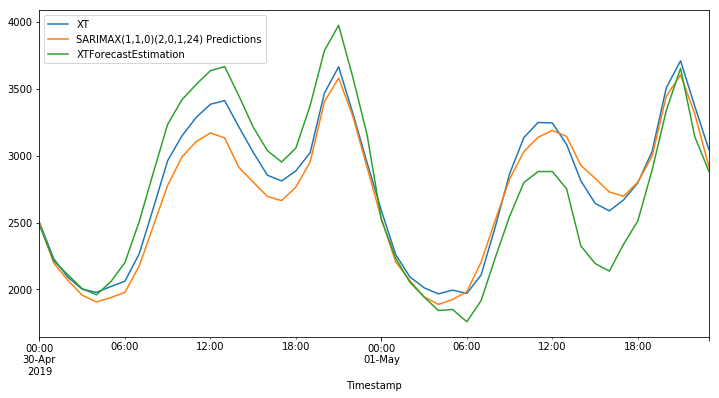

In [91]:
# Plot predictions against known values
ax = test['XT'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [92]:
from statsmodels.tools.eval_measures import mse,rmse

OurError= rmse(test['XT'], predictions)
TheirError = rmse(final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'], test['XT'])

In [93]:

TheirError

243.02998816611498

In [94]:
#WIN??
OurError

116.94986300810248

# Prophet

In [93]:
#import ProphetLibrary
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [94]:
#create holidays Dataframe for possible use by Prophet
holidays = pd.DataFrame({
    'ds': train.reset_index().query('Holiday == 1')['Timestamp'],
    'holiday': 'holiday'
})
holidays.head()

In [95]:
#fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)#, holidays=holidays)
prophet_model.fit(train['XT'].reset_index().rename(columns={'Timestamp':'ds', 'XT':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\ntarz\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [96]:
#predict
prophet_forecast = prophet_model.predict(df=test['XT'].reset_index().rename(columns={'Timestamp':'ds'}))

In [97]:
#store predictions
_ = prophet_model.plot_components(prophet_forecast)

In [ ]:
# Plot predictions against known values
fig, axes = plt.subplots(1, figsize=(16,6))
axes.plot(test.index, test['XT'], label='XT')
axes.plot(test.index, prophet_forecast['yhat'], label='Prophet', axes=axes)
final['XTForecastEstimation'].loc['2019-04-30':'2019-05-01'].plot(legend=True, axes=axes)
axes.autoscale(axis='x', tight=True)
axes.legend()

In [98]:
#calculate Error
from statsmodels.tools.eval_measures import mse,rmse
prophet_error= rmse(test['XT'], prophet_forecast['yhat'])

In [99]:
#worse
prophet_error

330.97786559210465

# RNN

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential

In [44]:
tf.reset_default_graph()

In [45]:
final=final['XT'].loc['2018-05-01':'2019-05-01']

In [46]:
final=pd.DataFrame(final)

In [47]:
final.head()

,XT
Timestamp,
2018-05-01 00:00:00,2677.633223
2018-05-01 01:00:00,2364.679692
2018-05-01 02:00:00,2203.407972
2018-05-01 03:00:00,2116.851557
2018-05-01 04:00:00,2073.180366


In [48]:
final.shape

(8784, 1)

In [49]:
train_set = final[:-48]

In [51]:
test_set = final[-48:]

In [52]:
test_set.head()

,XT
Timestamp,
2019-04-30 00:00:00,2501.842601
2019-04-30 01:00:00,2229.336789
2019-04-30 02:00:00,2090.021816
2019-04-30 03:00:00,2001.966833
2019-04-30 04:00:00,1977.424776


In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [54]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    rand_start=np.random.randint(0,len(training_data)-steps)
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps)
    y_batch=np.array(training_data[rand_start:rand_start + steps +1]).reshape(1,steps+1)
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)
    return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

In [724]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 24
# 100 neuron layer, play with this
num_neurons = 300
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.001 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 6000
# Size of the batch of data
batch_size = 1

In [725]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [726]:
# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.LSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

In [727]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [728]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [729]:
init = tf.global_variables_initializer()

In [730]:
saver = tf.train.Saver()

In [731]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.1594054
100 	MSE: 0.014192226
200 	MSE: 0.013373078
300 	MSE: 0.0085653225
400 	MSE: 0.0016364957
500 	MSE: 0.0029096715
600 	MSE: 0.0017208975
700 	MSE: 0.0013999194
800 	MSE: 0.001355229
900 	MSE: 0.0016213221
1000 	MSE: 0.0013293168
1100 	MSE: 0.0014801101
1200 	MSE: 0.0020425932
1300 	MSE: 0.001037419
1400 	MSE: 0.00065670814
1500 	MSE: 0.00083739246
1600 	MSE: 0.0012114252
1700 	MSE: 0.00096531725
1800 	MSE: 0.0013408602
1900 	MSE: 0.00057510525
2000 	MSE: 0.0009072788
2100 	MSE: 0.00069750455
2200 	MSE: 0.00047507844
2300 	MSE: 0.00065075274
2400 	MSE: 0.0014531551
2500 	MSE: 0.0012225426
2600 	MSE: 0.0015684288
2700 	MSE: 0.00039778405
2800 	MSE: 0.0013400698
2900 	MSE: 0.00080002
3000 	MSE: 0.0008322127
3100 	MSE: 0.0005620099
3200 	MSE: 0.00089870906
3300 	MSE: 0.0010425841
3400 	MSE: 0.000726745
3500 	MSE: 0.0010587974
3600 	MSE: 0.0008854843
3700 	MSE: 0.00041082106
3800 	MSE: 0.0009204466
3900 	MSE: 0.0005804645
4000 	MSE: 0.00081277353
4100 	MSE: 0.0003929058
420

In [732]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-48:])
    
    ## Now create a for loop that 
    for iteration in range(48):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


In [733]:
train_seed

[array([0.18456891]),
 array([0.1375574]),
 array([0.09874731]),
 array([0.05309964]),
 array([0.03021581]),
 array([0.02553209]),
 array([0.01410014]),
 array([0.03353712]),
 array([0.09413748]),
 array([0.17239842]),
 array([0.2298611]),
 array([0.24463428]),
 array([0.21842076]),
 array([0.1630024]),
 array([0.09119511]),
 array([0.06460893]),
 array([0.05509104]),
 array([0.05330115]),
 array([0.06669348]),
 array([0.10162873]),
 array([0.19080081]),
 array([0.24750171]),
 array([0.21385534]),
 array([0.16235988]),
 array([0.10174696]),
 array([0.05404555]),
 array([0.03126483]),
 array([0.01543865]),
 array([0.00763962]),
 array([0.01012893]),
 array([0.00136448]),
 array([0.01965958]),
 array([0.06743489]),
 array([0.12099651]),
 array([0.16555799]),
 array([0.19333156]),
 array([0.21578022]),
 array([0.21451658]),
 array([0.1690678]),
 array([0.13874727]),
 array([0.1149329]),
 array([0.10960331]),
 array([0.12625242]),
 array([0.15568221]),
 array([0.24265864]),
 array([0.28859

In [734]:
results = scaler.inverse_transform(np.array(train_seed[48:]).reshape(48,1))

In [735]:
test_set['Generated'] = results

C:\Users\ntarz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [736]:
test_set

,XT,Generated
Timestamp,,
2019-04-30 00:00:00,2501.842601,2431.716797
2019-04-30 01:00:00,2229.336789,2132.258301
2019-04-30 02:00:00,2090.021816,1977.086914
2019-04-30 03:00:00,2001.966833,1883.899536
2019-04-30 04:00:00,1977.424776,1833.161133
2019-04-30 05:00:00,2020.730916,1834.266235
2019-04-30 06:00:00,2061.331463,1915.359131
2019-04-30 07:00:00,2265.317645,2116.591064
2019-04-30 08:00:00,2610.171583,2449.625977


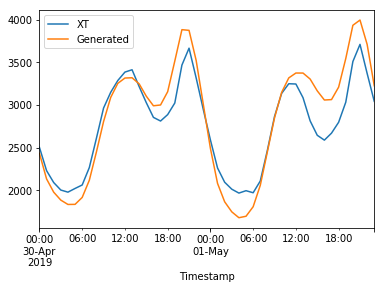

In [737]:
test_set.plot()

In [738]:
from statsmodels.tools.eval_measures import mse,rmse

OurError= rmse(test_set['XT'], test_set['Generated'])


In [739]:
#good
OurError

252.04923912458264